In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
#from sparse_batched_kmeans import kmeans

In [2]:
import numpy as np
import six
from sklearn import cluster


def _get_kmeans(n_clusters, init, n_init, batched=False):
    if batched:
        fun = cluster.MiniBatchKMeans
    else:
        fun = cluster.KMeans
    return fun(
        n_clusters=n_clusters,
        init=init,
        n_init=n_init
    )

funs = [cluster.KMeans, cluster.MiniBatchKMeans]
def __get_kmeans(x, n_clusters, init, n_init, batched=False):
    for fun in funs:
        t0 = time()
        out = fun(
            n_clusters=n_clusters,
            init=init,
            n_init=n_init
        ).fit(x)
        print('fun', fun,
              'time,', time() - t0, 
              'input', x.shape,
              'n_clusters', n_clusters,
              'n_init', n_init)
    return(out)


def get_kmeans(x, n_clusters, init, n_init, batched=False):
    if not batched:
        if n_init == 1:
            print('vanilla for', x.shape, n_clusters, n_init, 'batched', batched)
            fun = cluster.KMeans
        else:
            print('batched for', x.shape, n_clusters, n_init, 'batched', batched)
            fun = cluster.MiniBatchKMeans
    if batched:
        if n_init == 1:
            print('batched for', x.shape, n_clusters, n_init, 'batched', batched)
            fun = cluster.MiniBatchKMeans
        else:
            print('vanilla for', x.shape, n_clusters, n_init, 'batched', batched)
            fun = cluster.KMeans
    t0 = time()
    out = fun(
        n_clusters=n_clusters,
        init=init,
        n_init=n_init
    ).fit(x)
    print('took', time() - t0)
    return out


def kmeans(x, k=None, wbounds=None, n_init=20, max_iter=6, centers=None,
           verbose=False, batched=False):
    n, p = x.shape
    if k is None and centers is None:
        raise ValueError('k and centers are None.')
    if k is not None and centers is not None:
        if centers.shape[0] != k or centers.shape[1] != p:
            raise ValueError('Invalid shape of centers.')

    if wbounds is None:
        wbounds = np.linspace(1.1, np.sqrt(p), 20)
    if np.isscalar(wbounds):
        wbounds = np.asarray([wbounds])
    if wbounds.min() <= 1:
        raise ValueError('Each wbound must be > 1.')

    if centers is not None:
        #cs = get_kmeans(centers.shape[0], init=centers, n_init=1, batched=batched).fit(x).labels_
        cs = get_kmeans(x, centers.shape[0], init=centers, n_init=1, batched=batched).labels_
    else:
        #cs = get_kmeans(k, init='random', n_init=n_init, batched=batched).fit(x).labels_
        cs = get_kmeans(x, k, init='random', n_init=n_init, batched=batched).labels_

    out = []
    for i in range(len(wbounds)):
        ws = np.ones(p) * (1 / np.sqrt(p))
        ws_old = np.random.standard_normal(p)
        bcss_ws = None
        niter = 0
        while (np.sum(np.abs(ws - ws_old)) / np.sum(np.abs(ws_old)) > 1e-4 and
               niter < max_iter):
            niter += 1
            ws_old = ws
            if niter > 1:
                if k is not None:
                    cs = _update_cs(x, k, ws, cs, batched=batched)
                else:
                    cs = _update_cs(x, centers.shape[0], ws, cs, batched=batched)
            ws = _update_ws(x, cs, wbounds[i])
            bcss_ws = np.sum(_get_wcss(x, cs)[1] * ws)
        result = {'ws': ws, 'cs': cs, 'bcss_ws': bcss_ws, 'wbound': wbounds[i]}
        out.append(result)
        if verbose:
            six.print_('*-------------------------------------------------*')
            six.print_('iter:', i + 1)
            six.print_('wbound:', wbounds[i])
            six.print_('number of non-zero weights:', np.count_nonzero(ws))
            six.print_('sum of weights:', np.sum(ws), flush=True)
    return out


def permute(x, k=None, nperms=25, wbounds=None, nvals=10, centers=None,
            verbose=False, batched=False):
    n, p = x.shape
    if k is None and centers is None:
        raise ValueError('k and centers are None.')
    if k is not None and centers is not None:
        if centers.shape[0] != k or centers.shape[1] != p:
            raise ValueError('Invalid shape of centers.')
    if wbounds is None:
        wbounds = np.exp(
            np.linspace(np.log(1.2), np.log(np.sqrt(p) * 0.9), nvals))
    if wbounds.min() <= 1 or len(wbounds) < 2:
        raise ValueError('len(wbounds) and each wbound must be > 1.')

    permx = np.zeros((nperms, n, p))
    nnonzerows = None
    for i in range(nperms):
        for j in range(p):
            permx[i, :, j] = np.random.permutation(x[:, j])
    tots = None
    out = kmeans(x, k, wbounds, centers=centers, verbose=verbose, batched=batched)

    for i in range(len(out)):
        nnonzerows = _cbind(nnonzerows, np.sum(out[i]['ws'] != 0))
        bcss = _get_wcss(x, out[i]['cs'])[1]
        tots = _cbind(tots, np.sum(out[i]['ws'] * bcss))
    permtots = np.zeros((len(wbounds), nperms))
    for i in range(nperms):
        perm_out = kmeans(
            permx[i], k, wbounds, centers=centers, verbose=verbose, batched=batched)
        for j in range(len(perm_out)):
            perm_bcss = _get_wcss(permx[i], perm_out[j]['cs'])[1]
            permtots[j, i] = np.sum(perm_out[j]['ws'] * perm_bcss)

    gaps = np.log(tots) - np.log(permtots).mean(axis=1)
    bestw = wbounds[gaps.argmax()]
    out = {'bestw': bestw, 'gaps': gaps, 'wbounds': wbounds,
           'nnonzerows': nnonzerows}
    return out






### pysparcl/subfunc.py
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans


def _get_uw(ds, wbound, niter, uorth=None):
    n, p = ds.shape
    u = np.random.randn(p)
    w = (np.ones(p) / p) * wbound
    w_old = np.random.standard_normal(p)
    iter = 0
    if uorth is not None:
        if np.sum(np.abs(uorth - uorth.T)) > 1e-10:
            return None
        uorth = squareform(uorth)
        uorth /= np.sqrt(np.sum(np.square(uorth)))
    while (iter < niter and
           np.sum(np.abs(w_old - w) / np.sum(np.abs(w_old))) > 1e-4):
        if iter == 0:
            u = ds.dot(w.T)
        else:
            u = ds[:, argw >= lam].dot(w[argw >= lam].T)
        if uorth is not None:
            u -= uorth.dot(uorth.T.dot(u))
        iter += 1
        u = u / np.linalg.norm(u)
        w_old = w.copy()
        argw = np.maximum(u.dot(ds), 0).T
        lam = _binary_search(argw, wbound)
        w = _soft_thresholding(argw, lam)
        w /= np.linalg.norm(w)
    u = ds[:, argw >= lam].dot(w[argw >= lam].T) / np.sum(w)
    if uorth is not None:
        u -= uorth.dot(uorth.T.dot(u))
    u /= np.linalg.norm(u)
    w /= np.linalg.norm(w)
    crit = np.sum(u * (ds.dot(w.T)))
    u /= np.sqrt(2.)
    return u, w, crit


def _get_wcss(x, cs, ws=None):
    wcss_perf = np.zeros(x.shape[1])
    for i in np.unique(cs):
        mask = (cs == i)
        if np.sum(mask) > 1:
            wcss_perf += np.sum(
                np.square(x[mask, :] - np.mean(x[mask, :], axis=0)), axis=0)
    bcss_perf = np.sum(np.square(x - np.mean(x, axis=0)), axis=0) - wcss_perf
    return wcss_perf, bcss_perf


def _update_cs(x, k, ws, cs, batched=False):
    x = x[:, ws != 0]
    z = x * np.sqrt(ws[ws != 0])
    mus = None
    if cs is not None:
        for i in np.unique(cs):
            if np.sum(cs == i) > 1:
                mus = _rbind(mus, np.mean(z[cs == i, :], axis=0))
            if np.sum(cs == i) == 1:
                mus = _rbind(mus, z[cs == i, :])
    if mus is None:
        #km = get_kmeans(k, init='random', n_init=10, batched=batched).fit(z)
        km = get_kmeans(z, k, init='random', n_init=10, batched=batched)
    else:
        distmat = cdist(z, mus)
        nearest = distmat.argmin(axis=1)
        if len(np.unique(nearest)) == k:
            #km = get_kmeans(k, init=mus, n_init=1, batched=batched).fit(z)
            km = get_kmeans(z, k, init=mus, n_init=1, batched=batched)
        else:
            #km = get_kmeans(k, init='random', n_init=10, batched=batched).fit(z)
            km = get_kmeans(z, k, init='random', n_init=10, batched=batched)
    return km.labels_


def _update_ws(x, cs, wbound):
    wcss_perf = _get_wcss(x, cs)[0]
    tss_perf = _get_wcss(x, np.ones(x.shape[0]))[0]
    lam = _binary_search(-wcss_perf + tss_perf, wbound)
    ws_unscaled = _soft_thresholding(-wcss_perf + tss_perf, lam)
    return ws_unscaled / np.linalg.norm(ws_unscaled)





### pysparcl/utils.py
import numpy as np


def _rbind(x0, x1):
    if x0 is None:
        return x1
    else:
        return np.vstack((x0, x1))


def _cbind(x0, x1):
    if x0 is None:
        return x1
    else:
        return np.hstack((x0, x1))


def _soft_thresholding(x, d):
    return np.sign(x) * np.maximum(0, np.abs(x) - d)


def _binary_search(argu, sumabs):
    l2n_argu = np.linalg.norm(argu)
    if l2n_argu == 0 or np.sum(np.abs(argu / l2n_argu)) <= sumabs:
        return 0
    lam1 = 0
    lam2 = np.max(np.abs(argu)) - 1e-5
    iter = 1
    while iter <= 15 and (lam2 - lam1) > 1e-4:
        su = _soft_thresholding(argu, (lam1 + lam2) / 2.)
        if np.sum(np.abs(su / np.linalg.norm(su))) < sumabs:
            lam2 = (lam1 + lam2) / 2.
        else:
            lam1 = (lam1 + lam2) / 2.
        iter += 1
    return (lam1 + lam2) / 2.



In [86]:
num_data = 10000
num_dim = 100
wbounds = np.ones(2) * 1.1
np.random.seed(42)
x = np.random.normal(0, 1, (num_data, num_dim))

out = kmeans(x, k=num_dim, wbounds=wbounds, batched=False)

fun <class 'sklearn.cluster._kmeans.KMeans'> time, 3.7408642768859863 input (10000, 100) n_clusters 100 n_init 20
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 2.8327889442443848 input (10000, 100) n_clusters 100 n_init 20
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 0.579174280166626 input (10000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 1.4423065185546875 input (10000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 0.37325620651245117 input (10000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 1.1558516025543213 input (10000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 0.4932825565338135 input (10000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 1.223395824432373 input (10000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 0.4003896713256836 i

In [85]:
# more feature
num_data = 10000
num_dim = 1000
wbounds = np.ones(2) * 1.1
np.random.seed(42)
x = np.random.normal(0, 1, (num_data, num_dim))

out = kmeans(x, k=num_dim, wbounds=wbounds, batched=False)

fun <class 'sklearn.cluster._kmeans.KMeans'> time, 40.42266583442688 input (10000, 1000) n_clusters 1000 n_init 20
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 4.46082067489624 input (10000, 1000) n_clusters 1000 n_init 20
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 14.157558917999268 input (10000, 2) n_clusters 1000 n_init 10
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 2.9931752681732178 input (10000, 2) n_clusters 1000 n_init 10
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 0.7106714248657227 input (10000, 2) n_clusters 1000 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 1.5159926414489746 input (10000, 2) n_clusters 1000 n_init 1
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 12.433170080184937 input (10000, 2) n_clusters 1000 n_init 10
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 1.9959580898284912 input (10000, 2) n_clusters 1000 n_init 10
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 1.316397

In [84]:
# more data
num_data = 20000
num_dim = 100
wbounds = np.ones(2) * 1.1
np.random.seed(42)
x = np.random.normal(0, 1, (num_data, num_dim))

out = kmeans(x, k=num_dim, wbounds=wbounds, batched=False)

fun <class 'sklearn.cluster._kmeans.KMeans'> time, 11.009020566940308 input (20000, 100) n_clusters 100 n_init 20
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 2.3004260063171387 input (20000, 100) n_clusters 100 n_init 20
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 1.5243041515350342 input (20000, 5) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 3.561671257019043 input (20000, 5) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 0.9167678356170654 input (20000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 1.4513192176818848 input (20000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 1.1765313148498535 input (20000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 0.6138172149658203 input (20000, 2) n_clusters 100 n_init 1


In [87]:
# more more data
num_data = 40000
num_dim = 100
wbounds = np.ones(2) * 1.1
np.random.seed(42)
x = np.random.normal(0, 1, (num_data, num_dim))

out = kmeans(x, k=num_dim, wbounds=wbounds, batched=False)

fun <class 'sklearn.cluster._kmeans.KMeans'> time, 29.3149311542511 input (40000, 100) n_clusters 100 n_init 20
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 4.743725538253784 input (40000, 100) n_clusters 100 n_init 20
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 2.7280054092407227 input (40000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 2.5532727241516113 input (40000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 2.191694736480713 input (40000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 3.3424062728881836 input (40000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 2.107022523880005 input (40000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.MiniBatchKMeans'> time, 3.4028844833374023 input (40000, 2) n_clusters 100 n_init 1
fun <class 'sklearn.cluster._kmeans.KMeans'> time, 2.069201946258545 input 

It seems like whenever n_init > 1, batched is faster

Maybe only invoke batched in those cases?

In [93]:
# more more data
num_data = 50000
num_dim = 256
wbounds = np.ones(2) * 1.1
np.random.seed(42)
x = np.random.normal(0, 1, (num_data, num_dim))

out = kmeans(x, k=num_dim, wbounds=wbounds, batched=False)

batched for (50000, 256) 256 20 batched False
took 4.996211528778076
vanilla for (50000, 2) 256 1 batched False
took 7.136416673660278
vanilla for (50000, 2) 256 1 batched False
took 2.727417469024658
vanilla for (50000, 2) 256 1 batched False
took 0.13191938400268555
vanilla for (50000, 2) 256 1 batched False
took 0.31592869758605957
vanilla for (50000, 2) 256 1 batched False
took 1.0204589366912842
vanilla for (50000, 2) 256 1 batched False
took 1.220712661743164
vanilla for (50000, 2) 256 1 batched False
took 0.33739733695983887


In [94]:
out = kmeans(x, k=num_dim, wbounds=wbounds, batched=True)

vanilla for (50000, 256) 256 20 batched True
took 64.47499322891235
vanilla for (50000, 3) 256 10 batched True
took 74.72903847694397
batched for (50000, 2) 256 1 batched True
took 5.1238203048706055
batched for (50000, 2) 256 1 batched True
took 4.148303031921387
batched for (50000, 2) 256 1 batched True
took 3.083468198776245
batched for (50000, 2) 256 1 batched True
took 1.5394995212554932
batched for (50000, 2) 256 1 batched True
took 2.526333808898926


# Conclusion: Do batched whenever n_init > 1

In [3]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
#from sparse_batched_kmeans import kmeans, permute

In [2]:
# Try on real activations and compute gaps

In [4]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm

from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import pearsonr as corr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

global_seed = 20230831

from main_cifar10 import *

Using device: cuda
Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/cool_klindt/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


In [5]:
log_dir = 'results/test4/'
with open(os.path.join(log_dir, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)

results['layer1'].keys()

dict_keys(['output_shape', 'activations', 'activations_normed', 'kmeans_num_dic', 'kmeans_128', 'kmeans_128dist', 'kmeans_256', 'kmeans_256dist', 'kmeans_512', 'kmeans_512dist', 'data_train', 'data_test', 'data_train_kmeans_128', 'data_test_kmeans_128', 'data_train_kmeans_256', 'data_test_kmeans_256', 'data_train_kmeans_512', 'data_test_kmeans_512', 'probabilities', 'probabilities_kmeans_128', 'probabilities_kmeans_256', 'probabilities_kmeans_512', 'monosemanticity', 'monosemanticity_kmeans_128', 'monosemanticity_kmeans_256', 'monosemanticity_kmeans_512', 'kmeans_128_top', 'kmeans_128_topdist', 'data_train_kmeans_128_top', 'data_test_kmeans_128_top', 'monosemanticity_kmeans_128_top', 'kmeans_128_bottom', 'kmeans_128_bottomdist', 'data_train_kmeans_128_bottom', 'data_test_kmeans_128_bottom', 'monosemanticity_kmeans_128_bottom', 'kmeans_256_top', 'kmeans_256_topdist', 'data_train_kmeans_256_top', 'data_test_kmeans_256_top', 'monosemanticity_kmeans_256_top', 'kmeans_256_bottom', 'kmeans_2

In [6]:
x = results['layer1']['activations'].copy()
x.shape

(50000, 256)

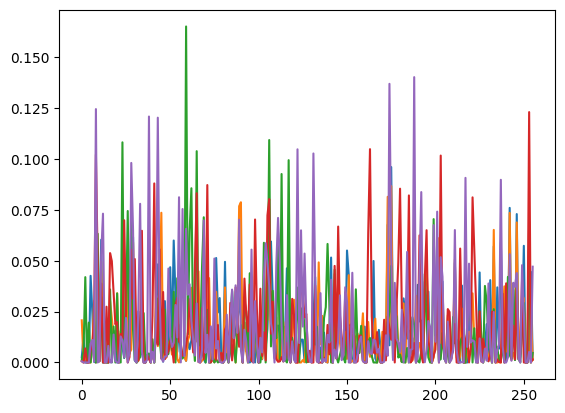

In [5]:
plt.plot(x[:5].T)

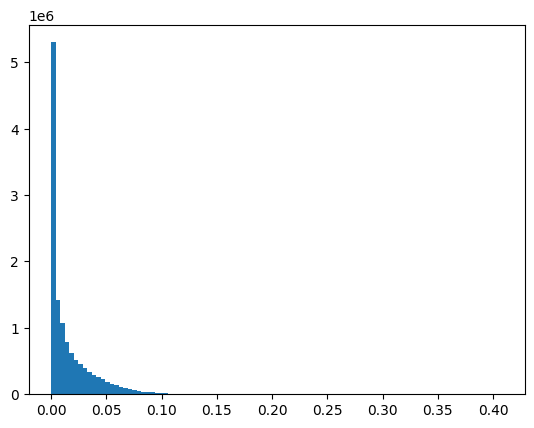

In [18]:
plt.hist(x.flatten(), 100)
plt.show()

In [7]:
# vanilla kmeans
n_clusters = x.shape[1]
t0 = time()
km_vanilla = MiniBatchKMeans(n_clusters=n_clusters).fit(x)
print(time() - t0)

8.37557578086853


In [7]:
km_vanilla.cluster_centers_.shape

(256, 256)

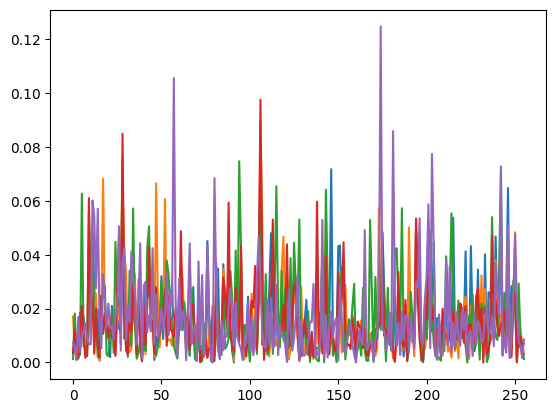

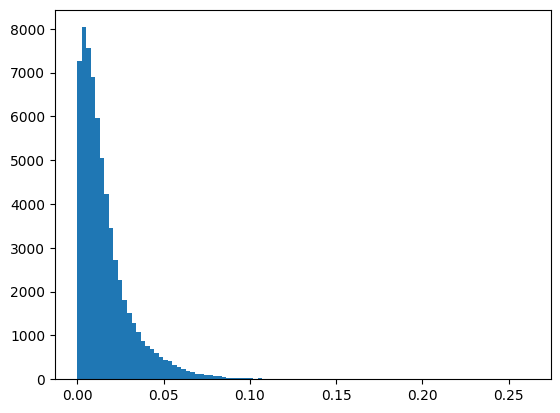

In [8]:
plt.plot(km_vanilla.cluster_centers_[:5].T)
plt.show()

plt.hist(km_vanilla.cluster_centers_.flatten(), 100)
plt.show()

In [8]:
# sparse kmeans
n_clusters = x.shape[1]
wbounds = np.ones(1) * 10
t0 = time()
km_sparse = kmeans(x, k=n_clusters, batched=False)
print(time() - t0)

batched for (50000, 256) 256 20 batched False
took 5.779558897018433
batched for (50000, 2) 256 10 batched False
took 1.5928120613098145
vanilla for (50000, 2) 256 1 batched False
took 5.25290322303772
batched for (50000, 18) 256 10 batched False
took 4.193034410476685
vanilla for (50000, 5) 256 1 batched False
took 15.145323038101196
vanilla for (50000, 5) 256 1 batched False
took 4.405999660491943
vanilla for (50000, 5) 256 1 batched False
took 4.17181134223938
vanilla for (50000, 5) 256 1 batched False
took 2.7534899711608887
vanilla for (50000, 34) 256 1 batched False
took 6.6870949268341064
vanilla for (50000, 11) 256 1 batched False
took 6.792034149169922
vanilla for (50000, 9) 256 1 batched False
took 7.061316013336182
vanilla for (50000, 8) 256 1 batched False
took 9.229530572891235
vanilla for (50000, 9) 256 1 batched False
took 6.544510126113892
vanilla for (50000, 43) 256 1 batched False
took 11.57902717590332
vanilla for (50000, 30) 256 1 batched False
took 5.67223548889160

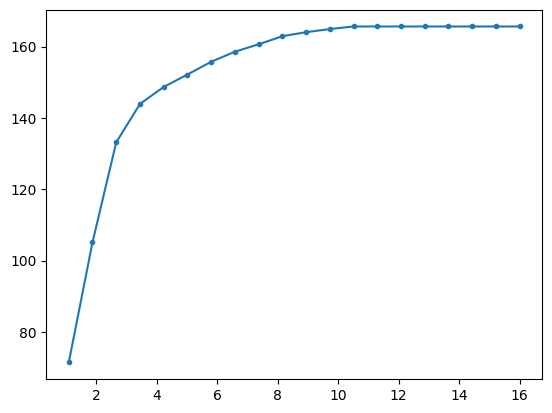

In [16]:
wbounds = [_['wbound'] for _ in km_sparse]
bcss_ws = [_['bcss_ws'] for _ in km_sparse]
plt.plot(wbounds, bcss_ws, '.-')

In [45]:
ind = 4
km_sparse[ind]['ws'].shape, km_sparse[ind]['cs'].shape

((256,), (50000,))

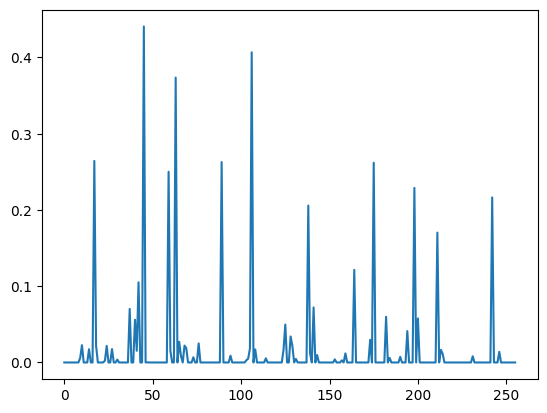

In [46]:
plt.plot(km_sparse[ind]['ws'])

In [47]:
# get cluster centers
from sparse_batched_kmeans import fast_kmeans

def get_centers(x, k, ws, cs):
    x = x[:, ws != 0]
    z = x * np.sqrt(ws[ws != 0])
    mus = None
    if cs is not None:
        for i in np.unique(cs):
            if np.sum(cs == i) > 1:
                mus = _rbind(mus, np.mean(z[cs == i, :], axis=0))
            if np.sum(cs == i) == 1:
                mus = _rbind(mus, z[cs == i, :])
    if mus is None:
        km = fast_kmeans(k, init='random', n_init=10).fit(z)
    else:
        distmat = cdist(z, mus)
        nearest = distmat.argmin(axis=1)
        if len(np.unique(nearest)) == k:
            km = fast_kmeans(k, init=mus, n_init=1).fit(z)
        else:
            km = fast_kmeans(k, init='random', n_init=10).fit(z)
    distances = km.transform(z)
    return km, distances

km_sparse_best, distances = get_centers(x, k=n_clusters, ws=km_sparse[ind]['ws'], cs=km_sparse[ind]['cs'])

In [48]:
km_sparse_best.cluster_centers_.shape, distances.shape

((256, 59), (50000, 256))

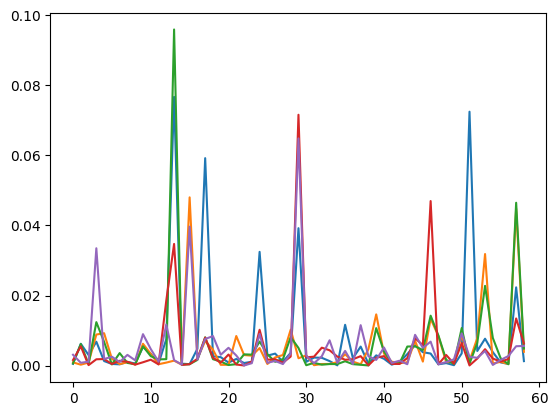

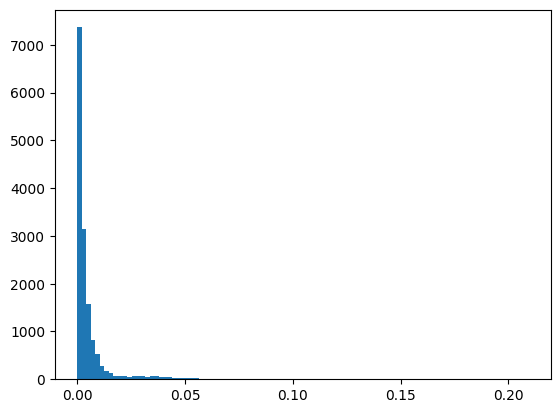

In [49]:
plt.plot(km_sparse_best.cluster_centers_[:5].T)
plt.show()

plt.hist(km_sparse_best.cluster_centers_.flatten(), 100)
plt.show()

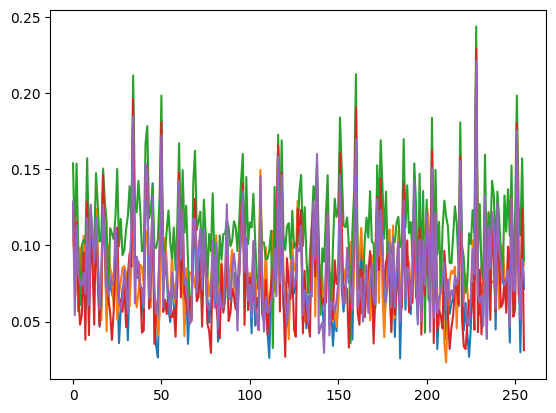

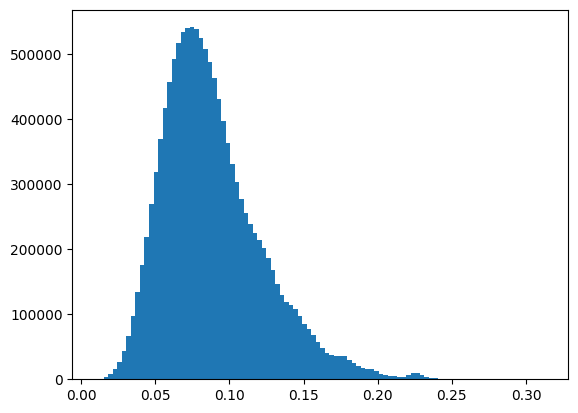

In [50]:
plt.plot(distances[:5].T)
plt.show()

plt.hist(distances.flatten(), 100)
plt.show()

In [38]:
plot_meis(
    -distances,
    -distances.mean(0),
    results['inputs'],
    'test_sparse_kmeans.png'
)

<Figure size 1210x1100 with 0 Axes>

In [51]:
data_train, data_test = get_mei_data(
    -distances, results['inputs']
)

In [52]:
scores = get_monosemanticity(data_train)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f141a3abcd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f141a3abe80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f14467469b0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f141a3ab4c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f141a394790>,
 'means': []}

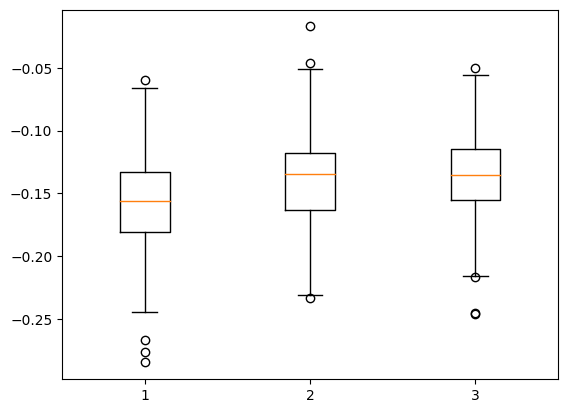

In [44]:
plt.boxplot([
    -results['layer1']['monosemanticity'],
    -results['layer1']['monosemanticity_kmeans_256'],
    -scores
])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f13bc334400>,
 'caps': [<matplotlib.lines.Line2D at 0x7f13bc337460>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f13bc3358d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f13bc337310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f13bc3372e0>,
 'means': []}

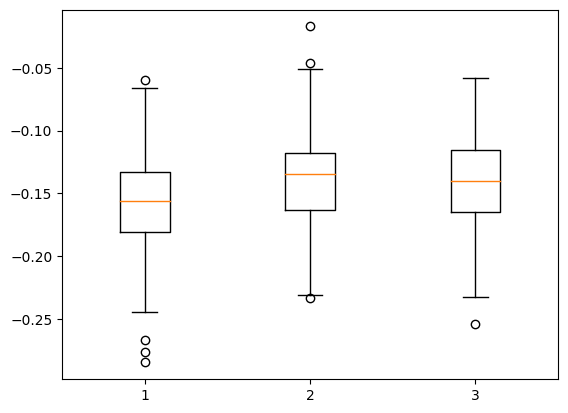

In [53]:
plt.boxplot([
    -results['layer1']['monosemanticity'],
    -results['layer1']['monosemanticity_kmeans_256'],
    -scores
])

In [56]:
scores = []
for i in range(len(km_sparse)):
    wbound = km_sparse[i]['wbound']
    print(i, wbound)
    km_sparse_best, distances = get_centers(
        x, k=n_clusters, ws=km_sparse[i]['ws'], cs=km_sparse[i]['cs'])
    print(km_sparse_best.cluster_centers_.shape)
    data_train, data_test = get_mei_data(
        -distances, results['inputs']
    )
    scores.append(get_monosemanticity(data_train))
    print(scores[-1].mean(), scores[-1].std())


0 1.1
(256, 2)
0.16303503605013248 0.03553934389177083
1 1.8842105263157896
(256, 5)
0.1520611785381334 0.03786072723783047
2 2.668421052631579
(256, 9)
0.14552828739397228 0.0350900642844675
3 3.4526315789473685
(256, 22)
0.1462158903304953 0.035603577329887934
4 4.2368421052631575
(256, 59)
0.14110454451292753 0.03511331312209487
5 5.021052631578947
(256, 89)
0.13965448251110502 0.03190419610016519
6 5.805263157894737
(256, 111)
0.14013238974439446 0.03393953473524398
7 6.589473684210526
(256, 148)
0.13812170378514566 0.03547936733375077
8 7.373684210526315
(256, 186)
0.1372750813170569 0.03506361369486761
9 8.157894736842104
(256, 218)
0.13846143649425358 0.03314411704421927
10 8.942105263157895
(256, 244)
0.13919249027094338 0.03360621860573513
11 9.726315789473684
(256, 256)
0.13887429203896318 0.03209862859782767
12 10.510526315789473
(256, 256)
0.1389756872667931 0.0339748829699122
13 11.294736842105262
(256, 256)
0.1388739612302743 0.0340747768761317
14 12.078947368421053
(256,

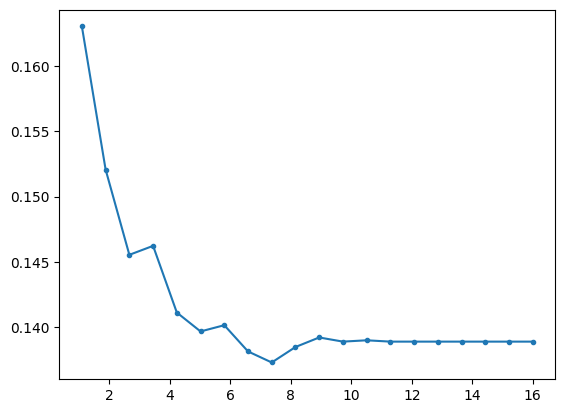

In [58]:
plt.plot(wbounds, [_.mean() for _ in scores], '.-')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1394581ab0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1394581540>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f13945814e0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f1394580d00>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f13945810f0>,
 'means': []}

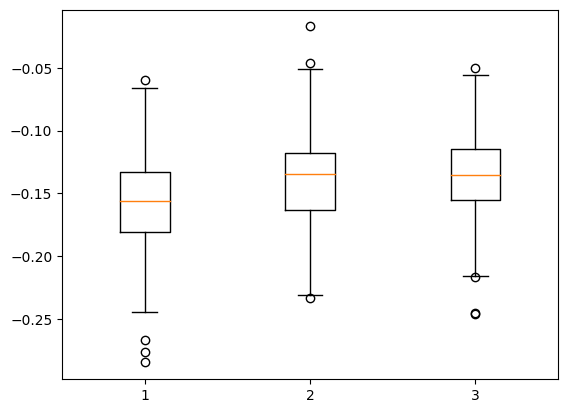

In [59]:
plt.boxplot([
    -results['layer1']['monosemanticity'],
    -results['layer1']['monosemanticity_kmeans_256'],
    -scores[8]
])

### Sparse k Means switches of features, but this is not what we want.

We want clusters that look at subcircuits, but different subcircuits for different clusters, so maybe sparsify...?

### Normalize activations and find optimal wbound and then keep for all experiments?